---

<center> <h1> <span style='color:#C7B097'> AltaML Hackathon 2022 </span> </h2> </center>
<center> <h2> <span style='color:#98AFC7'> Charity Classification </span> </h1> </center>
<center> <img src="https://altaml.com/media/ul4ibm45/logo-for-dark.png?mode=pad&width=200&height=70&format=webp&quality=100" alt="altaml" style="width:200px;"> </center>
<center> <img src="https://img-prod-cms-rt-microsoft-com.akamaized.net/cms/api/am/imageFileData/RE1Mu3b?ver=5c31" alt="microsoft" style="width:200px;"> </center>

---

#
<center> <h2> <span style='color:#C7B097'> Table of Content </span> </h2> </center>

* [1 - Introduction](#1-introduction)
  * [1.1 - Import libraries](#11---import-libraries)
    * [1.1.1 - Configurations](#111---configurations)
* [2 - Data](#2-data)
  * [2.1 - Charity Navigator Dataset](#21-charity-navigator-dataset)
    * [2.1.1 - Data Preparation](#211---data-preparation)
    * [2.1.2 - Data Wrangling](#212---data-wrangling)
    * [2.1.3 - TF-IDF with n-grams](#213---tf-idf-with-n-grams)
    * [2.1.4 - Feature Selection](#214---feature-selection)
    * [2.1.5 - Oversampling and Undersampling for inbalanced data](#215---oversampling-and-undersampling-for-inbalanced-data)
* [3 - Classification](#3---classification)
  * [3.1 - Logistic Regression](#31---logistic-regression)
  * [3.2 - Gradient Boosting XGBoost](#32---gradient-boosting-xgboost)
    * [3.2.1 - Feature Importance (First 30 features)](#321---feature-importance-first-30-features)
* [4 - Final Results](#4---final-results)
* [5 - Test loading the pickle file](#5-test-loading-the-pickle-file)

# 1 - Introduction

#### Description: 

This project aims to classify the charities among 10 different categories. The dataset have information of 8400 different US charities as rated by CharityNavigator.org

Possible categories for each charity:

1. Animals
2. Arts, Culture, Humanities
3. Community Development
4. Education
5. Environment
6. Health
7. Human Services
8.  Human and Civil Rights
9.  Religion
10. Research and Public Policy


#### Dataset:
Link : 
<a href="https://www.kaggle.com/datasets/katyjqian/charity-navigator-scores-expenses-dataset?resource=download"> Charity Navigator Dataset</a>

The data is a public service of Charity Navigator, but the data is likely owned by individual charities. Charity Navigator collects this data. This data was webscraped in May 2019 but uses rating details mostly from 2017

## 1.1 - Import libraries

In [463]:
# Core libraries
import pandas as pd
import numpy as np
import warnings
from IPython.core.interactiveshell import InteractiveShell
import os

# NLP
import nltk.corpus
nltk.download("stopwords")
from nltk.corpus import stopwords

# Visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
import plotly.express as px


# Features Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Feature Selection
from sklearn.feature_selection import SelectKBest, chi2


# Machine Learning
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.tree import DecisionTreeClassifier, plot_tree # Decision Tree
from sklearn.ensemble import RandomForestClassifier # Random Forest
from xgboost import XGBClassifier, plot_importance # Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier # Gradient Boosting
from sklearn.neural_network import MLPClassifier # Neural Networks
from sklearn.neighbors import KNeighborsClassifier # KNeighbors
from sklearn.svm import SVC # Support Vector Machine 
from sklearn.model_selection import train_test_split # Split the data
import pickle # Format to save the ML model


# Metrics
from sklearn.metrics import (f1_score, accuracy_score, recall_score, 
precision_score, classification_report)
from sklearn.metrics import make_scorer 

# Inbalance Treatment
from imblearn.over_sampling import SMOTE, RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler

# Utilities functions
import utils


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leonardoqueiroz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 1.1.1 - Configurations

In [464]:
# Show multiple outputs at the same cell
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings("ignore") # Ignore warnings
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 16, 6 # Set the standard plot size
%matplotlib inline

In [465]:
accuracy = make_scorer(accuracy_score)
recall = make_scorer(recall_score, average='macro')
precision = make_scorer(precision_score, average='macro')
f1 = make_scorer(f1_score, average='macro')
os.makedirs('outputs', exist_ok=True)

In [466]:
smote = True
metric = accuracy #f1 # Metric used for optimization
metric_name = 'Accuracy' #'F1'
search_params = True # Search for the best parameters

# 2 - Data

## 2.1 - Charity Navigator Dataset

[id1]: # "Accountability & Transparency Score - %"
[id2]: # "Charity class"
[id3]: # "Mission & Description."
[id4]: # "ID number."
[id5]: # "Total Expenses in (Program , Funding ,Administrative)."
[id6]: # "Administrative Expenses Percentage (of total expenses)%."
[id7]: # "Funding Efficiency in (amount spent to raise 1 in donations)."
[id8]: # "Funding Expenses Percentage (of total expenses)."
[id9]: # "Program Expenses Percentage (of total expenses)."
[id10]: # "Financial Score (out of 100)."
[id11]: # "Name of Leader."
[id12]: # "Compensation of Leader in."
[id13]: # "Compensation of Leader Percentage."
[id14]: # "Tagline."
[id15]: # "Name of Charity."
[id16]: # "Total Revenue."
[id17]: # "Overall Score (out of 100)."
[id18]: # "State."
[id19]: # "Subcategory."
[id20]: # "Size of Charity (based on Total Expenses)."
[id21]: # "Program Expenses in (amount spent on program & services it delivers)."
[id22]: # "Funding Expenses in (amount spent on raising money)."
[id23]: # "Administrative Expenses in $ (amount spent on overhead, staff, meeting costs)."

| Index | Feature (Input) | Short Description | Unit/Format |
|:-------:|:-----------------|:------------------------------------------------------|:-------------------------------------|
| 1 | [`ascore`][id1] | Accountability & Transparency Score | % |
| 2 | [`category`][id2] | Charity class (`10 categories that will be used as output`) | dimensionless |
| 3 | [`description`][id3] | Mission & Description (`Used as the only input`) | dimensionless |
| 4 | [`EIN`][id4] | ID number | dimensionless |
| 5 | [`tot_exp`][id5] | Total Expenses in (Program , Funding ,Administrative) | dimensionless |
| 6 | [`admin_exp_p`][id6] | Administrative Expenses Percentage (of total expenses) | % |
| 7 | [`fund_eff`][id7] | Funding Efficiency in (amount spent to raise 1 in donations) | dimensionless |
| 7 | [`fund_exp_p`][id8] | Funding Expenses Percentage (of total expenses) | dimensionless |
| 8 | [`program_exp_p`][id9] | Program Expenses Percentage (of total expenses) | % |
| 9 | [`fscore`][id10] | Financial Score (out of 100) | dimensionless |
| 10 | [`leader`][id11] | Name of Leader | dimensionless |
| 11 | [`leader_comp`][id12] | Compensation of Leader in | dimensionless |
| 12 | [`leader_comp_p`][id13] | Compensation of Leader Percentage | dimensionless |
| 12 | [`motto`][id14] | Tagline | dimensionless |
| 13 | [`name`][id15] | Name of Charity | dimensionless |
| 14 | [`tot_rev`][id16] | Total Revenue | $ |
| 15 | [`score`][id17] | Overall Score (out of 100) | dimensionless |
| 16 | [`state`][id18] | State | dimensionless |
| 17 | [`subcategory`][id19] | Subcategory | dimensionless |
| 18 | [`size`][id20] | Size of Charity (based on Total Expenses) | dimensionless |
| 19 | [`program_exp`][id21] | Program Expenses in (amount spent on program & services it delivers) | dimensionless |
| 20 | [`fund_exp`][id22] | Funding Expenses in (amount spent on raising money) | dimensionless |
| 21 | [`admin_exp`][id23] | Administrative Expenses in $ (amount spent on overhead, staff, meeting costs) | dimensionless |


### 2.1.1 - Data Preparation

In [467]:
# Load data
df_charity = pd.read_csv("CLEAN_charity_data.csv")

#### For the propose of this project we are going to use only the `description` feature as input and the `category` as output

In [468]:
df_charity.columns

Index(['ascore', 'category', 'description', 'ein', 'tot_exp', 'admin_exp_p',
       'fund_eff', 'fund_exp_p', 'program_exp_p', 'fscore', 'leader',
       'leader_comp', 'leader_comp_p', 'motto', 'name', 'tot_rev', 'score',
       'state', 'subcategory', 'size', 'program_exp', 'fund_exp', 'admin_exp'],
      dtype='object')

In [469]:
# Description sample
df_charity['description'][1]

'Serving the metropolitan Baltimore area and the state of Maryland, the mission of WYPR Your Public Radio is to broadcast programs of intellectual integrity and cultural merit which enrich the minds and spirits of our listeners and ultimately strengthen the communities we serve. WYPR adheres to the highest standards of journalistic and artistic excellence. It delivers educational, informational, cultural, and entertainment programming as a public services to the broadest possible audience.'

In [470]:
# Drop all features but category and description
df_charity.drop(columns=['ascore','ein','tot_exp','admin_exp_p','fund_eff',
'fund_exp_p', 'program_exp_p', 'fscore', 'leader',
'leader_comp', 'leader_comp_p', 'motto', 'name', 'tot_rev', 'score',
'state', 'subcategory', 'size', 'program_exp', 'fund_exp', 'admin_exp'], inplace = True)
# Drop the rows with the category `international`
df_charity = df_charity[df_charity.category != 'International']

In [471]:
utils.data_check(df_charity)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7798 entries, 0 to 8407
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     7798 non-null   object
 1   description  7798 non-null   object
dtypes: object(2)
memory usage: 182.8+ KB


None

Number of nan values: 0
Number of duplicated rows: 6


,count,unique,top,freq
category,7798,10,Human Services,2379
description,7798,7781,Our Mission,4


,category,description
0,Environment,Working with Oregonians to enhance our quality...
1,"Arts, Culture, Humanities",Serving the metropolitan Baltimore area and th...
2,Religion,VSS Catholic Communications is dedicated to an...
3,"Arts, Culture, Humanities",The mission of the Utah Symphony & Opera is to...
4,Human Services,"Funded solely by the footwear industry, Two Te..."


Data Shape: (7798, 2)


In [472]:
np.unique(df_charity['category'])

array(['Animals', 'Arts, Culture, Humanities', 'Community Development',
       'Education', 'Environment', 'Health', 'Human Services',
       'Human and Civil Rights', 'Religion', 'Research and Public Policy'],
      dtype=object)

In [473]:
top_prod = df_charity.groupby('category').size().reset_index().rename(
    columns={0: 'total'}).sort_values('total', ascending=False)
fig = px.pie(top_prod, values='total', names='category', width=800, height=800,
             color_discrete_sequence=px.colors.sequential.thermal, 
             title="Charity Categories")
fig.show()

In [474]:
top_prod

,category,total
6,Human Services,2379
1,"Arts, Culture, Humanities",1218
5,Health,847
2,Community Development,803
3,Education,667
0,Animals,454
8,Religion,450
4,Environment,429
7,Human and Civil Rights,346
9,Research and Public Policy,205


#### Observations:
1. Both `description` and `category` are object dtype
2. There are 6 duplicated rows
3. There are 10 individual categories (after delete the `International`) for the charities with most being `Human Services` category
4. The plot above displays the distribution of all charity categories

### 2.1.2 - Data Wrangling

In [475]:
# Transform the object type into category type for the category target
df_charity["category"] = df_charity["category"].astype("category")
df_charity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7798 entries, 0 to 8407
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   category     7798 non-null   category
 1   description  7798 non-null   object  
dtypes: category(1), object(1)
memory usage: 129.8+ KB


In [476]:
df_charity["description_no_punctuation"] = df_charity["description"].apply(utils.remove_punctuation)
df_charity

,category,description,description_no_punctuation
0,Environment,Working with Oregonians to enhance our quality...,working with oregonians to enhance our quality...
1,"Arts, Culture, Humanities",Serving the metropolitan Baltimore area and th...,serving the metropolitan baltimore area and th...
2,Religion,VSS Catholic Communications is dedicated to an...,vss catholic communications is dedicated to an...
3,"Arts, Culture, Humanities",The mission of the Utah Symphony & Opera is to...,the mission of the utah symphony opera is to ...
4,Human Services,"Funded solely by the footwear industry, Two Te...",funded solely by the footwear industry two ten...
...,...,...,...
8403,"Arts, Culture, Humanities","Founded in 1900, Yaddo is an artists' communit...",founded in 1900 yaddo is an artists community ...
8404,Religion,Yad L'Achim was established in 1950. It is a n...,yad lachim was established in 1950 it is a non...
8405,Human Services,Yad Ezra opened its doors in 1990 with the pur...,yad ezra opened its doors in 1990 with the pur...
8406,Human Services,"Rawhide, where commitment and compassion meet....",rawhide where commitment and compassion meet l...


In [477]:
df_charity.drop_duplicates(inplace=True)
df_charity.reset_index(inplace = True, drop = True)

In [478]:
df_charity.duplicated().sum()

0

In [479]:
# Removing Stop words
stop_words = stopwords.words("english")
# print(sorted(stop_words))
# print(len(stop_words))

In [480]:
func = lambda x: ' '.join([word for word in x.split() if word not in (stop_words)])
df_charity["description_clean"] = df_charity["description_no_punctuation"].apply(func)

In [481]:
df_charity.drop(["description_no_punctuation"], axis = 1, inplace = True)
df_charity.head()

,category,description,description_clean
0,Environment,Working with Oregonians to enhance our quality...,working oregonians enhance quality life buildi...
1,"Arts, Culture, Humanities",Serving the metropolitan Baltimore area and th...,serving metropolitan baltimore area state mary...
2,Religion,VSS Catholic Communications is dedicated to an...,vss catholic communications dedicated answerin...
3,"Arts, Culture, Humanities",The mission of the Utah Symphony & Opera is to...,mission utah symphony opera give great perform...
4,Human Services,"Funded solely by the footwear industry, Two Te...",funded solely footwear industry two ten footwe...


### 2.1.3 - TF-IDF with n-grams
(Term Frequency–Inverse Document Frequency)

In [482]:
vectorizer = TfidfVectorizer(
    lowercase = True, 
    stop_words = stop_words, 
    ngram_range = (1, 2), 
    min_df = 0.009, 
    max_df = 0.99
)

X = vectorizer.fit_transform(df_charity["description_clean"])

In [483]:
print("="*30)
print(f"Number of feature names: {len(vectorizer.get_feature_names())}")
print("="*30)
# The first 50 features
print(f"The first 50 features:\n{np.transpose(vectorizer.get_feature_names())[:50]}")
print("="*30)
print(f"Number of rows: {len(X.toarray())}")
print("="*30)

Number of feature names: 1118
The first 50 features:
['100' '12' '18' '1971' '1972' '1976' '1977' '1981' '1982' '1983' '1984'
 '1985' '1986' '1987' '1988' '1989' '1990' '1991' '1992' '1993' '1995'
 '20' '200' '2000' '25' '30' '40' '50' '501c3' '60' 'ability' 'able'
 'abuse' 'abused' 'academic' 'academy' 'access' 'accessible' 'accomplish'
 'achieve' 'achievement' 'acres' 'across' 'across country' 'act' 'action'
 'active' 'actively' 'activities' 'addition']
Number of rows: 7792


In [484]:
df_charity_description_tfidf = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
df_charity_description_tfidf["category"] = df_charity["category"]
df_charity_description_tfidf.head(3)

,100,12,18,1971,1972,1976,1977,1981,1982,1983,...,year,yearround,years,york,york city,young,young people,youth,youth development,category
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,Environment
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,"Arts, Culture, Humanities"
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.156886,0.0,0.0,0.0,0.0,0.0,0.0,Religion


In [485]:
cat = np.unique(df_charity_description_tfidf.category)
display(cat)
print(f"Number of Categories: {len(cat)}")

array(['Animals', 'Arts, Culture, Humanities', 'Community Development',
       'Education', 'Environment', 'Health', 'Human Services',
       'Human and Civil Rights', 'Religion', 'Research and Public Policy'],
      dtype=object)

Number of Categories: 10


In [486]:
# Set all features and the target to numbers that represent each values decribed on table above.
category_dict = {
    'Human Services':0 ,
    'Health' : 1, 
    'Education': 2, 
    'Arts, Culture, Humanities':3 ,
    'Religion' : 4, 
    'Research and Public Policy': 5,
    # 'International':6,
    'Community Development' : 6, 
    'Animals': 7,
    'Human and Civil Rights':8,
    'Environment' : 9}

data = df_charity_description_tfidf.replace(category_dict)
# data.drop(["description", "description_clean"], axis=1, inplace=True)
data

,100,12,18,1971,1972,1976,1977,1981,1982,1983,...,year,yearround,years,york,york city,young,young people,youth,youth development,category
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,9
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,3
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.156886,0.000000,0.0,0.0,0.0,0.00000,0.0,4
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,3
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.152168,0.000000,0.0,0.0,0.0,0.00000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7787,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.000000,0.108416,0.0,0.0,0.0,0.00000,0.0,3
7788,0.238788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.1657,0.0,0.175913,0.000000,0.0,0.0,0.0,0.00000,0.0,4
7789,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0
7790,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.32254,0.0,0


In [487]:
target = "category"
features = list(data.drop(target, axis=1))
# print(f"Feature: \n {features}")

In [488]:
print(f"Target: {target}")

Target: category


### 2.1.4 - Feature Selection
Let's reduce the amount of features

In [604]:
X,y = data.iloc[:,:-1], data.iloc[:,-1]

In [605]:
X.shape

(7792, 1118)

In [606]:
selector = SelectKBest(chi2, k=1118) # Reducing the features didn't improve the results
X_new = selector.fit_transform(X, y)

In [607]:
X_new.shape

(7792, 1118)

In [608]:
cols = selector.get_support(indices=True)
features_new = list(np.array(features)[cols])
X_new = pd.DataFrame(X_new, columns=features_new)

In [609]:
# data = pd.concat([X, y], axis=1)
data_new = pd.concat([X_new, y], axis=1)

In [610]:
# X_new = X
# features_new = features
# data_new = data

In [611]:
# Data split
train, test = train_test_split(
    data_new, test_size=0.20, stratify=data_new[target], random_state=1)
print(data_new.shape)
print(train.shape)
print(test.shape)
print(train.shape[0] + test.shape[0])


(7792, 1119)
(6233, 1119)
(1559, 1119)
7792


In [612]:
print(train[target].value_counts())
print(test[target].value_counts())

0    1901
3     973
1     676
6     642
2     534
7     363
4     360
9     343
8     277
5     164
Name: category, dtype: int64
0    476
3    244
1    169
6    160
2    133
7     91
4     90
9     86
8     69
5     41
Name: category, dtype: int64


In [613]:
data_new['category'].value_counts()

0    2377
3    1217
1     845
6     802
2     667
7     454
4     450
9     429
8     346
5     205
Name: category, dtype: int64

The `stratify` parameter is to keep the same proportions of the classes in the target for both train and test dataframes.

### 2.1.5 - Oversampling and Undersampling for inbalanced data

Both training and testing data for the target are still inbalanced.

There are too many moderately adapted students and too few highly-adapted students. Let's create an alternative dataset with oversampling and undersampling in case our models are not tought correctly on the original train datasets.

Duplicate rows to increase class 2 (High level of adaptability).

In [614]:
if smote:
    oversample = SMOTE()
    train[features_new], train[target] = oversample.fit_resample(train.drop(
        ["category"], axis=1), train["category"])

In [615]:
# Train and Test set after applying oversampling
print(train[target].value_counts())
print(test[target].value_counts())


1    1555
0    1515
3     772
2     693
6     513
4     291
7     280
9     270
8     221
5     123
Name: category, dtype: int64
0    476
3    244
1    169
6    160
2    133
7     91
4     90
9     86
8     69
5     41
Name: category, dtype: int64


# 3 - Classification

## 3.1 - Logistic Regression

In [616]:
test.shape

(1559, 1119)

**************************************************
Training metrics:
   Accuracy    Recall  Precision  F1-score
0  0.921386  0.942972   0.884828  0.909496
**************************************************
Test metrics:
   Accuracy    Recall  Precision  F1-score
0  0.842207  0.818803    0.79666  0.805633
**************************************************






**************************************************
Training metrics per class:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      1515
           1       0.97      0.94      0.95      1555
           2       0.89      0.90      0.89       693
           3       0.96      0.95      0.95       772
           4       0.84      0.97      0.90       291
           5       0.72      0.99      0.84       123
           6       0.92      0.95      0.93       513
           7       0.99      0.95      0.97       280
           8       0.75      0.95      0.84       221
           9     

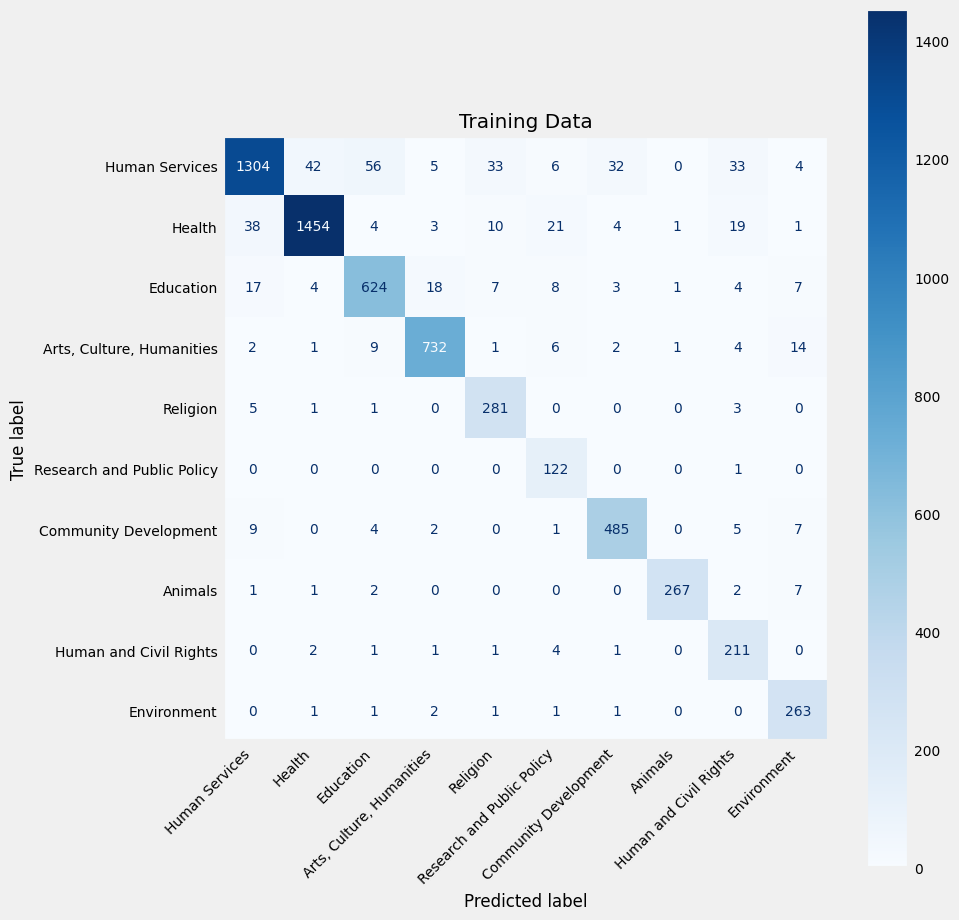

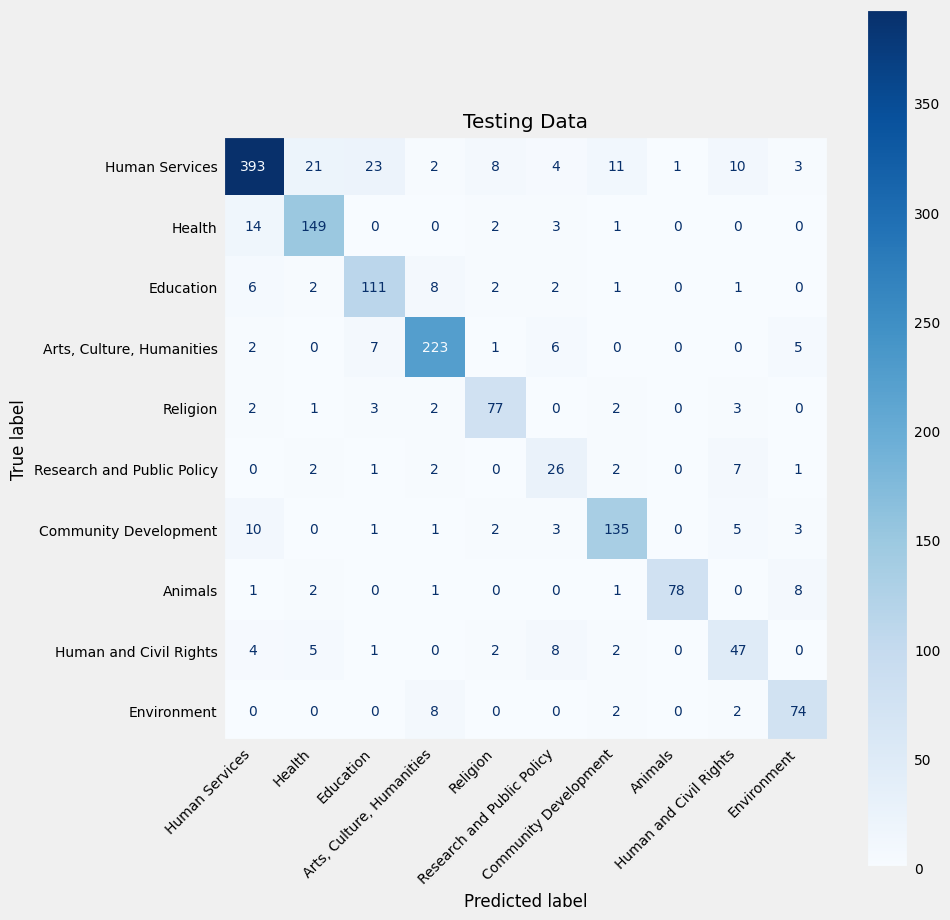

In [617]:
# %%time
# Training model
model_lr = LogisticRegression()

# Parameters to test
# params = {
#     "solver": ("newton-cg", "lbfgs"),
#     "max_iter": tuple(range(20, 35, 5)),
#     "class_weight": ["balanced", None],
#     'multi_class': ['auto'],
#     'random_state': [1],
# }

# Best parameters
params = {
    'solver': 'newton-cg',
    'max_iter': 8,
    'class_weight': 'balanced',
    'multi_class': 'auto',
    'random_state': 1,
}

pred_lr_test = utils.results(
    model=model_lr, 
    params=params, 
    train=train, 
    test=test, 
    features=features_new,
    target=target,
    metric=metric, 
    metric_name=metric_name,
    search_params=False)
# 0.920263
# 0.842207

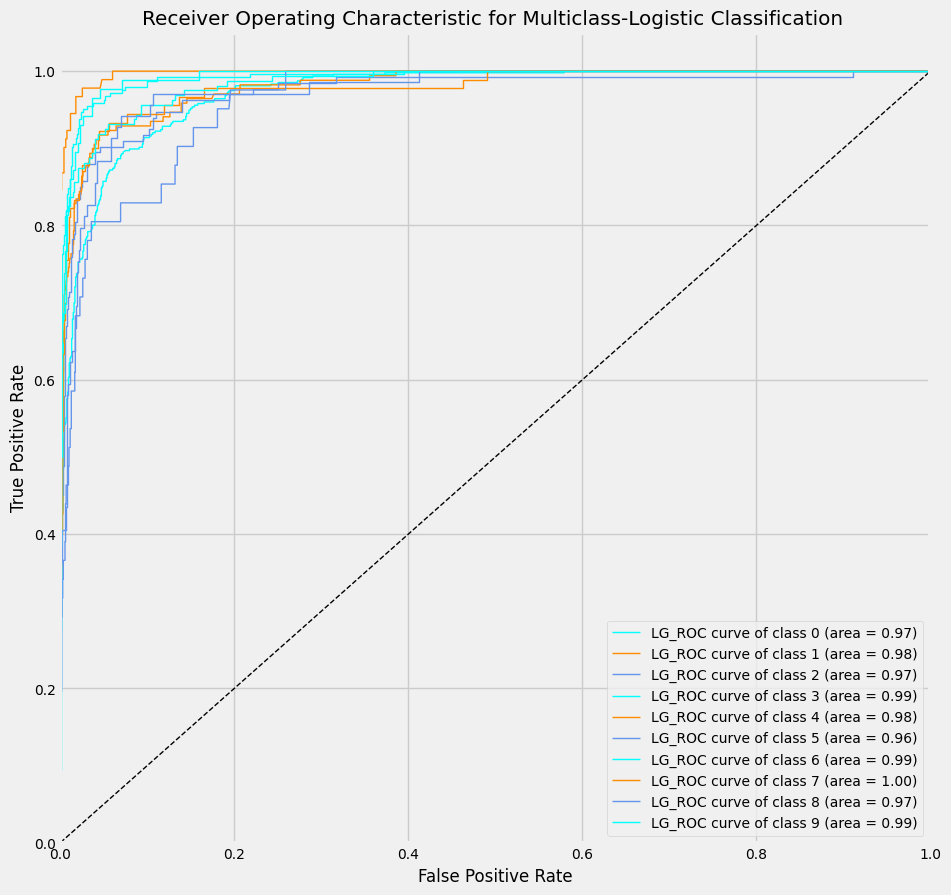

AUC: 0.9926269754811412


In [618]:
pred_prob_lg = model_lr.predict_proba(test[features_new])
utils.pr_curve(
    model_name='Multiclass-Logistic', 
    target=test[target], 
    pred_prob=pred_prob_lg
    )

In [619]:
pickle.dump(model_lr, open('outputs/model_lr.pkl', 'wb')) # Save the Logistic regression model as pickle file

### 3.2.2 - Feature importance (First 10 features)

In [620]:
lg_imp = pd.DataFrame(model_lr.coef_[0], columns = ["Weights"], index = features_new)
lg_imp= lg_imp.sort_values("Weights", ascending = False)
lg_imp

,Weights
food,3.974437
services,2.722797
youth,2.570810
homeless,2.280603
children,2.266762
...,...
world,-1.197562
dogs,-1.199831
animals,-1.317495
public,-1.671559


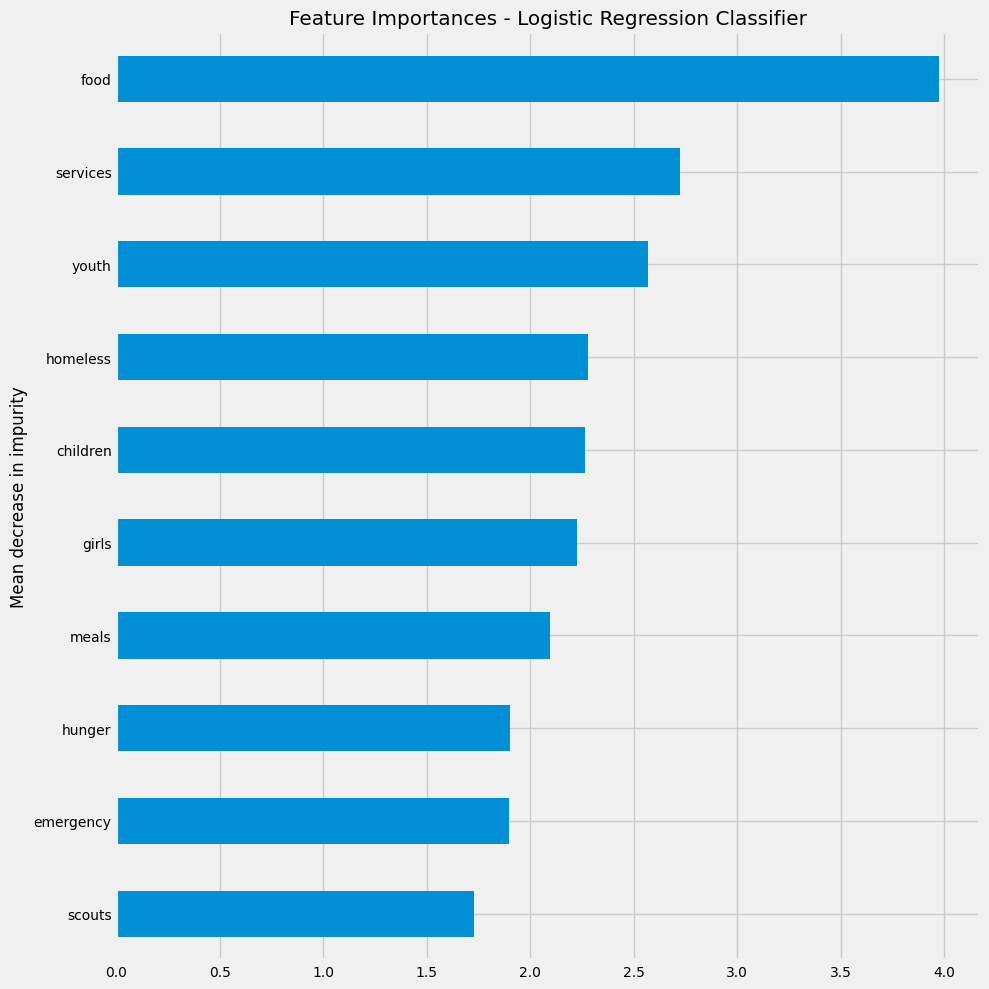

In [621]:
logistic_importances = pd.Series(model_lr.coef_[0], index = features_new)

fig, ax = plt.subplots()
logistic_importances.sort_values(ascending = False)[:10][::-1].plot.barh(ax = ax)

ax.set_title("Feature Importances - Logistic Regression Classifier")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout();

## 3.2 - Gradient Boosting (XGBoost)

[XGBClassifier](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier) from the `XGBoost` package.

**************************************************
Training metrics:
   Accuracy    Recall  Precision  F1-score
0  0.962297  0.942519   0.963418  0.952579
**************************************************
Test metrics:
   Accuracy    Recall  Precision  F1-score
0  0.814625  0.741267    0.78982  0.762017
**************************************************






**************************************************
Training metrics per class:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1515
           1       0.99      0.98      0.98      1555
           2       0.97      0.95      0.96       693
           3       0.98      0.97      0.98       772
           4       0.97      0.93      0.95       291
           5       0.97      0.90      0.93       123
           6       0.99      0.94      0.97       513
           7       0.98      0.94      0.96       280
           8       0.94      0.90      0.92       221
           9     

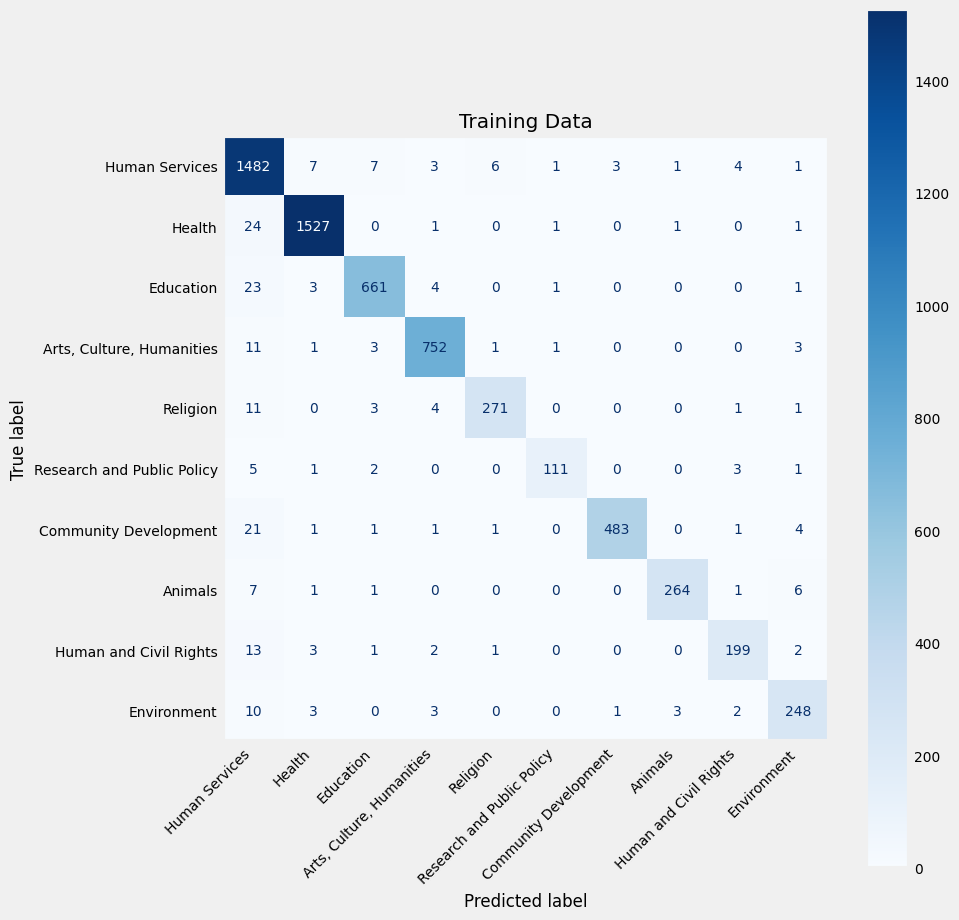

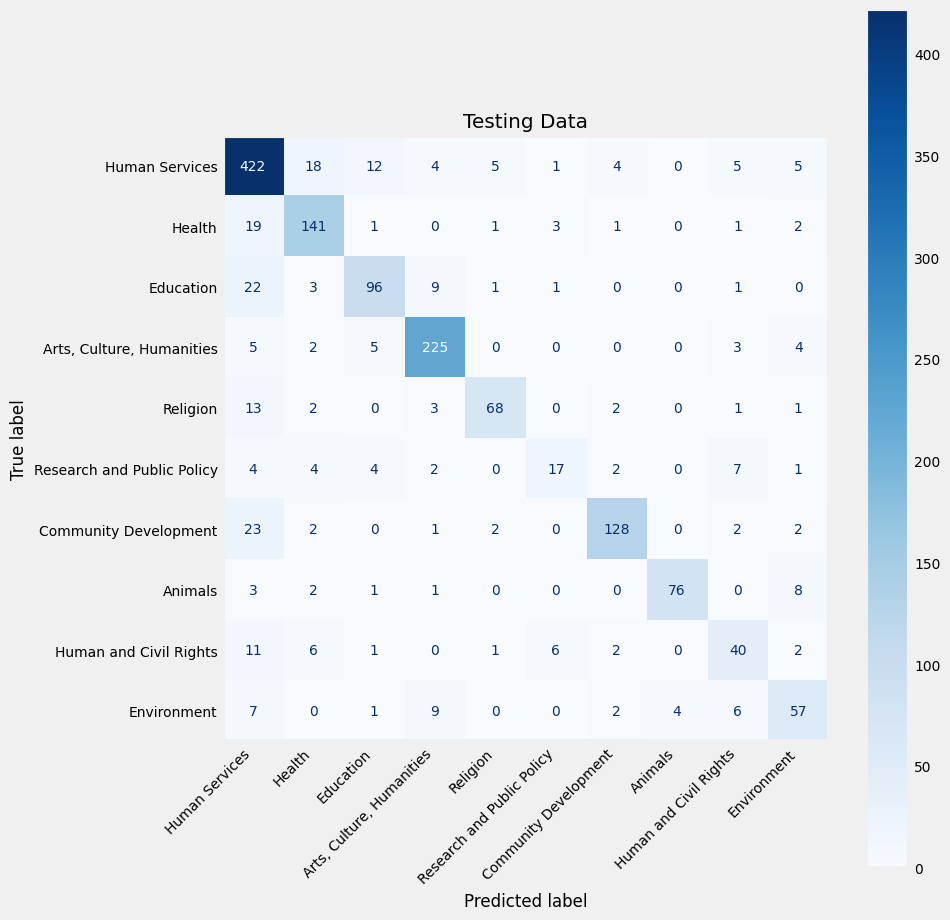

In [655]:
# %%time
# Training model
model_xgb = XGBClassifier()

# Parameters to test
# params = {
#     'max_depth': [6],
#     'n_estimators': tuple(range(50,56,1)),
#     'tree_method': ["approx"],
#     'random_state': [1],
#     'enable_categorical': [True],
#     'gamma':[i/10.0 for i in range(5)],
#     }

# Best parameters
params = {
    'max_depth': 6,
    'n_estimators': 52,
    'tree_method': 'approx',
    'random_state': 1,
    'enable_categorical': True,
    'gamma': 0.2,
    'lambda': 3,
    'alpha': 2
    }

pred_xgb_test = utils.results(
    model=model_xgb, 
    params=params, 
    train=train, 
    test=test, 
    features=features_new,
    target=target,
    metric=metric, 
    metric_name=metric_name,
    search_params=False)

# 0.967592
# 0.819756

In [656]:
pickle.dump(model_xgb, open('outputs/model_xgb.pkl', 'wb')) # Save the XXBoost model as pickle file

### 3.2.2 - Feature importance (First 10 features)

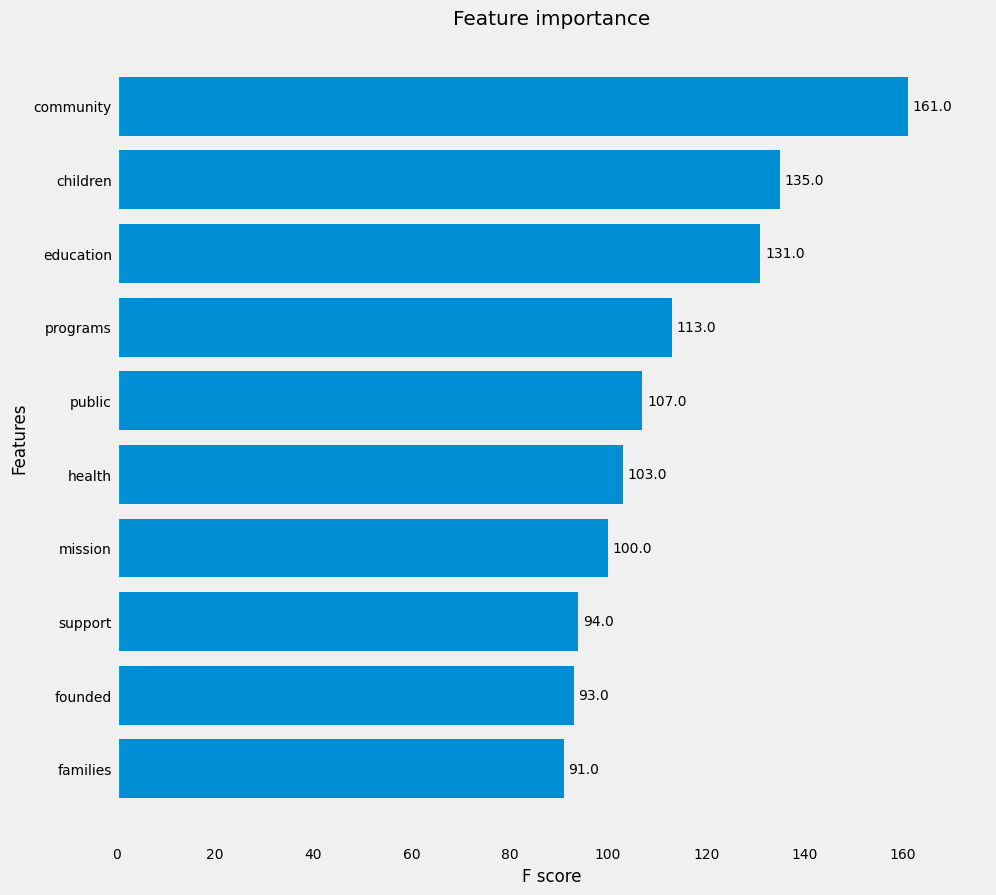

In [657]:
plot_importance(model_xgb, height=0.8, grid=False, max_num_features=10);

# 4 - Final Results

In [658]:
lr  = utils.model_metrics(test[target], pred_lr_test)  # Logistic Regression
xgb = utils.model_metrics(test[target], pred_xgb_test) # Gradient Boosting XGBoot

Merge all model results into one sigle DataFrame

In [659]:
models = [lr, xgb]
results = pd.concat(models, ignore_index=True)*100
results.rename(index={
    0:"Logistic Regression", 
    1:"Gradient Boosting (XGBoost)", 
    }, inplace=True)
results.index.name = 'Models'


In [660]:
results.style\
    .format('{:.2f}')\
    .highlight_max(color='green')\
    .highlight_min(color='red')


,Accuracy,Recall,Precision,F1-score
Models,,,,
Logistic Regression,84.22,81.88,79.67,80.56
Gradient Boosting (XGBoost),81.46,74.13,78.98,76.20


# 5. Test loading the pickle file

In [946]:
model_lr = pickle.load(open("outputs/model_lr.pkl", 'rb'))

#### Example

In [958]:
n = 1
description = df_charity['description'][n]
category = df_charity['category'][n]

print("Description:\n", description)
print("\nCategory: ", category)

Description:
 Serving the metropolitan Baltimore area and the state of Maryland, the mission of WYPR Your Public Radio is to broadcast programs of intellectual integrity and cultural merit which enrich the minds and spirits of our listeners and ultimately strengthen the communities we serve. WYPR adheres to the highest standards of journalistic and artistic excellence. It delivers educational, informational, cultural, and entertainment programming as a public services to the broadest possible audience.

Category:  Arts, Culture, Humanities


#### Step 1 - Remove ponctuation

In [948]:
description_no_punctuation = utils.remove_punctuation(description)

#### Step 2 - Remove stop words

In [949]:
stop_words = stopwords.words("english")
clean_text = lambda x: ' '.join([word for word in x.split() if word not in (stop_words)])
description_clean = clean_text(description_no_punctuation)

#### Step 3 - TF-IDF with n-grams (Vectorize)
(Term Frequency–Inverse Document Frequency)

In [950]:
vectorizer = TfidfVectorizer(
    lowercase = True, 
    stop_words = stop_words, 
    ngram_range = (1, 2), 
    min_df = 0, 
    max_df = 1
)

# X = vectorizer.fit_transform(pd.Series(description_clean))
X = vectorizer.fit_transform([description_clean])

In [951]:
df_charity_description_tfidf = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
df_charity_description_tfidf.head(3)

,adheres,adheres highest,area,area state,artistic,artistic excellence,audience,baltimore,baltimore area,broadcast,...,standards journalistic,state,state maryland,strengthen,strengthen communities,ultimately,ultimately strengthen,wypr,wypr adheres,wypr public
0,0.106,0.106,0.106,0.106,0.106,0.106,0.106,0.106,0.106,0.106,...,0.106,0.106,0.106,0.106,0.106,0.106,0.106,0.212,0.106,0.106


In [952]:
df_all = pd.DataFrame(np.nan, index=[0], columns=features)
df_all

,100,12,18,1971,1972,1976,1977,1981,1982,1983,...,would,year,yearround,years,york,york city,young,young people,youth,youth development
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [954]:
data = df_all.fillna(df_charity_description_tfidf)
data = data.fillna(0)

In [955]:
cat = model_lr.predict(data)

In [956]:
category_dict = {
    0: 'Human Services',
    1: 'Health', 
    2: 'Education',
    3: 'Arts, Culture, Humanities',
    4: 'Religion', 
    5: 'Research and Public Policy',
    6: 'Community Development', 
    7: 'Animals',
    8: 'Human and Civil Rights',
    9: 'Environment'
}

result = category_dict[cat[0]]
result

'Arts, Culture, Humanities'

In [945]:
# print(features, end='')